# Test new dataset class

In [63]:
from typing import Callable, Dict, List, Optional, Tuple, Union
from pathlib import Path

import h5py
# не удалять! import hdf5plugin !
import hdf5plugin
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm

In [64]:
class FSCCDataset(Dataset):
    file_types = ['inputs', 'targets']
    h5_reserved_names: List[str] = ['train_multi_inputs', 'train_multi_targets', 'train_cite_inputs',
                                    'train_cite_targets', 'test_multi_inputs', 'test_cite_inputs']

    dataflows = {'cite': {'train': {'inputs': None, 'targets': None},
                          'test': {'inputs': None}},
                 'multi': {'train': {'inputs': None, 'targets': None},
                           'test': {'inputs': None}}}

    metadata = None
    meta_unique_vals: Dict = {}
    metadata_file: str = 'metadata.csv'
    meta_transform_names: List[str] = ['day', 'donor', 'cell_type']
    meta_names: List[str] = ['day', 'donor', 'cell_type', 'technology']
    meta_keys: List[str] = ['cell_id', 'day', 'donor', 'cell_type', 'technology']

    col_name: str = 'axis0'
    pos_name: str = 'position'
    index_name: str = 'cell_id'
    cell_id_name: str = "axis1"
    target_name: str = 'gene_id'
    features_name: str = "block0_values"

    def __init__(self,
                 dataset_path: Union[str, Path],
                 task: str, mode: str,
                 meta_transform: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):
        self.task = task
        self.mode = mode
        self.data_ids = None
        self.data_shapes = None
        self.dataset_path = dataset_path

        self.transform = transform
        self.target_transform = target_transform
        self.meta_transform = meta_transform
        # init dataset
        self._read_task_dataset(dataset_path)

    def _read_metadata(self, path: str) -> pd.DataFrame:
        df = pd.read_csv(path, index_col=self.index_name)
        for key in self.meta_names:
            self.meta_unique_vals[key] = list(df[key].unique())

        return df

    def _transform_metalabels(self, meta_dict: Dict, cell_id: str) -> Dict:
        if self.meta_transform:
            if self.meta_transform == 'index':
                for key in self.meta_transform_names:
                    meta_dict[key] = self.meta_unique_vals[key].index(self.metadata[key][cell_id])
            elif self.meta_transform == 'one_hot':
                for key in self.meta_transform_names:
                    one_hot_vector = np.zeros((len(self.meta_unique_vals[key]),))
                    one_hot_vector[self.meta_unique_vals[key].index(self.metadata[key][cell_id])] = 1
                    meta_dict[key] = one_hot_vector
            else:
                raise ValueError(f"The argument 'meta_transform' can only take values from a list "
                                 f"['index', 'one_hot', None], but '{self.meta_transform}' was found.")
        else:
            meta_dict = {key: self.metadata[key][cell_id] for key in self.meta_names}

        return meta_dict

    def _get_task_flow(self, folder_path: Path, mode: str, task: str, file_type: str) -> None:
        file_name = '_'.join([mode, task, file_type])
        print(f"[ Reading {file_name}.h5 file ... ]")
        f_path = str(folder_path.joinpath(f"{file_name}.h5").absolute())
        flow, feature_shape = self.get_hdf5_flow(f_path)
        # write data in structure
        self.dataflows[task][mode][file_type] = flow
        self.data_shapes[task][mode][file_type] = feature_shape
        print(f"[ Reading {file_name}.h5 file is complete. ]")

    def _read_task_dataset(self, folder_path: Union[str, Path]) -> None:
        self.data_shapes = {self.task: {self.mode: {s: None for s in self.file_types}}}

        if isinstance(folder_path, str):
            folder_path = Path(folder_path)
        # read metadata file
        self.metadata = self._read_metadata(str(folder_path.joinpath(self.metadata_file)))
        # read all h5 files
        if self.mode == 'train':
            for file_type in self.file_types:
                self._get_task_flow(folder_path, self.mode, self.task, file_type)
        elif self.mode == 'test':
            self._get_task_flow(folder_path, self.mode, self.task, self.file_types[0])
        else:
            raise ValueError(f"Argument 'mode' can only take values from a list: ['train', 'test'], "
                             f"but {self.mode} was found.")

        self.data_ids = self._set_data_ids()

    def _set_data_ids(self):
        feature_flow = self.dataflows[self.task][self.mode]['inputs']
        return [x.decode("utf-8") for x in feature_flow[self.cell_id_name]]

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, item: int) -> Dict:
        cell_id = self.data_ids[item]
        features = self.dataflows[self.task][self.mode]['inputs']
        meta_data = {self.index_name: cell_id}  # self.pos_name: features[self.col_name][item].decode("utf-8")
        meta_data = self._transform_metalabels(meta_data, cell_id)

        x = features[self.features_name][item]
        if self.transform:
            x = self.transform(x)

        meta_data[self.file_types[0]] = x

        if self.dataflows[self.task][self.mode].get('targets'):
            targets = self.dataflows[self.task][self.mode]['targets']
            # meta_data[self.target_name] = targets[self.cell_id_name][item].decode("utf-8")
            y = targets[self.features_name][item]

            if self.target_transform:
                y = self.target_transform(y)

            meta_data[self.file_types[1]] = y

            return meta_data
        else:
            return meta_data

    def get_hdf5_flow(self, file_path: str):
        file_flow = h5py.File(file_path, 'r')

        file_keys = list(file_flow.keys())
        assert len(file_keys) == 1, AssertionError(f"Incorrect file format, '{file_path}' file have more than one "
                                                   f"group: {file_keys}.")

        file_name = file_keys[0]
        assert file_name in self.h5_reserved_names, \
            AssertionError(f"Incorrect file format, group name must be in {self.h5_reserved_names}, "
                           f"but {file_name} was found.")

        datasets_names = list(file_flow[file_name])
        assert self.features_name in datasets_names, AssertionError(f"Incorrect file format, dataset name "
                                                                    f"{self.features_name} was not found in hdf5 file "
                                                                    f"datasets list.")
        assert self.cell_id_name in datasets_names, AssertionError(f"Incorrect file format, dataset name "
                                                                   f"{self.cell_id_name} was not found in hdf5 file "
                                                                   f"datasets list.")
        assert self.col_name in datasets_names, AssertionError(f"Incorrect file format, dataset name {self.col_name} "
                                                               f"was not found in hdf5 file datasets list.")

        lines, features_shape = file_flow[file_name][self.features_name].shape

        return file_flow[file_name], (lines, features_shape)

    def reindex_dataset(self,
                        day: Optional[Union[int, List[int]]] = None,
                        donor: Optional[Union[int, List[int]]] = None,
                        cell_type: Optional[Union[str, List[str]]] = None) -> None:
        conditions = []
        if (day is not None) and isinstance(day, int):
            conditions.append((self.metadata['day'] == day))
        elif (day is not None) and isinstance(day, list):
            conditions.append((self.metadata['day'].isin(day)))

        if (donor is not None) and isinstance(donor, int):
            conditions.append((self.metadata['donor'] == donor))
        elif (donor is not None) and isinstance(donor, list):
            conditions.append((self.metadata['donor'].isin(donor)))

        if (cell_type is not None) and isinstance(cell_type, int):
            conditions.append((self.metadata['cell_type'] == cell_type))
        elif (cell_type is not None) and isinstance(cell_type, list):
            conditions.append((self.metadata['cell_type'].isin(cell_type)))

        if len(conditions) > 0:
            feature_flow = self.dataflows[self.task][self.mode]['inputs']
            ids = {x.decode("utf-8") for x in feature_flow[self.cell_id_name]}

            final_cond = conditions[0]
            if len(conditions) > 1:
                for cond in conditions[1:]:
                    final_cond &= cond

            cond_index = set(self.metadata[final_cond].index)
            self.data_ids = list(cond_index & ids)

    def rebase(self, task: Optional[str] = None, mode: Optional[str] = None):
        if task is not None:
            self.task = task
        if mode is not None:
            self.mode = mode

        self._read_task_dataset(self.dataset_path)
        self.data_ids = self._set_data_ids()

    def set_length(self, length: int) -> None:
        self.data_ids = self.data_ids[:length]


In [65]:
dataset_folder = '/home/mks/PycharmProjects/multimodal_single_cell_integration/dataset/'

In [66]:
train_dataset = FSCCDataset(dataset_folder, 'multi', 'train')
test_dataset = FSCCDataset(dataset_folder, 'multi', 'test')

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]
[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


In [5]:
train_dataset.meta_unique_vals

{'day': [3, 4, 7, 2, 10],
 'donor': [27678, 32606, 13176, 31800],
 'cell_type': ['MasP', 'MkP', 'NeuP', 'HSC', 'EryP', 'MoP', 'BP', 'hidden'],
 'technology': ['citeseq', 'multiome']}

In [6]:
test_dataset.meta_unique_vals

{'day': [3, 4, 7, 2, 10],
 'donor': [27678, 32606, 13176, 31800],
 'cell_type': ['MasP', 'MkP', 'NeuP', 'HSC', 'EryP', 'MoP', 'BP', 'hidden'],
 'technology': ['citeseq', 'multiome']}

In [7]:
train_dataset.data_shapes

{'multi': {'train': {'inputs': (105942, 228942), 'targets': (105942, 23418)}}}

In [8]:
test_dataset.data_shapes

{'multi': {'test': {'inputs': (55935, 228942), 'targets': None}}}

In [9]:
test_dataset[0]

{'day': 2,
 'donor': 27678,
 'cell_type': 'hidden',
 'technology': 'multiome',
 'inputs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}

In [67]:
train_atac_len = train_dataset.data_shapes['multi']['train']['inputs'][0]
test_atac_len = test_dataset.data_shapes['multi']['test']['inputs'][0]
atac_count = train_atac_len + test_atac_len
print(f"Количество ATAC фичей во всем датасете равно: {atac_count};")

Количество ATAC фичей во всем датасете равно: 161877;


# Строим класстер по дням

In [68]:
days = train_dataset.meta_unique_vals['day']

In [69]:
days

[3, 4, 7, 2, 10]

In [70]:
atac_shape = train_dataset.data_shapes['multi']['train']['inputs'][1]
print(f"ATAC shape = {atac_shape};")

ATAC shape = 228942;


In [71]:
len(train_dataset)

105942

In [15]:
mean_vectors = {d: np.zeros((atac_shape,)) for d in train_dataset.meta_unique_vals['day']}
# start calculation
all_data = [train_dataset, test_dataset]
for dataset in all_data:
    for ind in tqdm(range(len(dataset))):
        meta = dataset[ind]
        mean_vectors[meta['day']] += meta['inputs']

for key, val in mean_vectors.items():
    mean_vectors[key] = val / atac_count

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55935/55935 [01:12<00:00, 770.66it/s]


## Строим графики для усредненых по дням значений

In [16]:
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_names = [name for name, _ in mcolors.BASE_COLORS.items()]
print(color_names)
print(len(color_names))

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
8


In [106]:
%matplotlib inline

In [17]:
X = [val for _, val in mean_vectors.items()]
tags = [key for key, _ in mean_vectors.items()]

# build pca
pca = PCA(n_components=2)
features = pca.fit(X).transform(X)

Text(0.5, 1.0, 'PCA of Mean ATAC features')

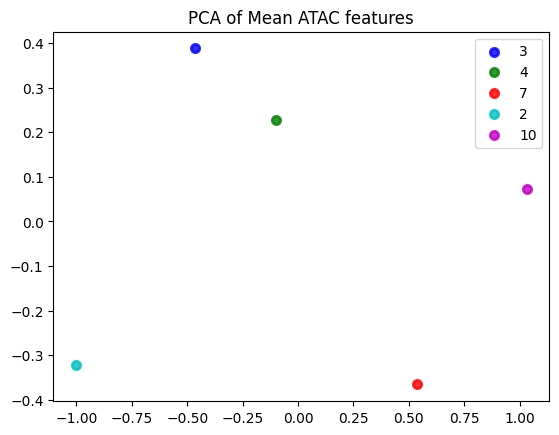

In [18]:
# build plot
lw = 2
plt.figure()
colors = color_names[:len(days)]

for color, f, target_name in zip(colors, features, tags):
    plt.scatter(f[0], f[1], color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.title("PCA of Mean ATAC features")

## Строим графики кластеров для неусредненных по дням значений

In [19]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


In [20]:
# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

Text(0.5, 1.0, 'PCA of ATAC features groups by day')

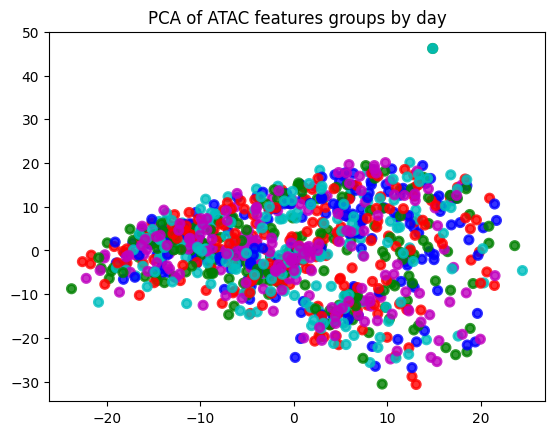

In [31]:
# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

-------------------------------------------

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

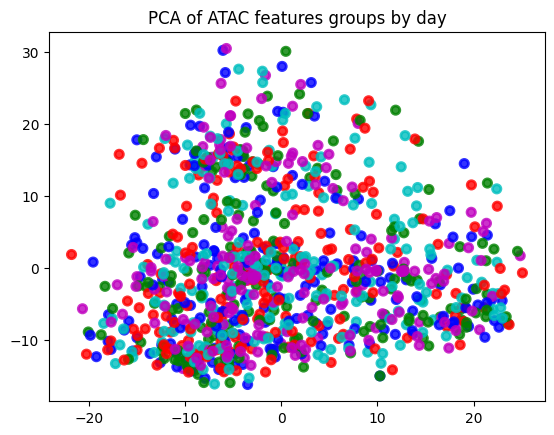

In [32]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

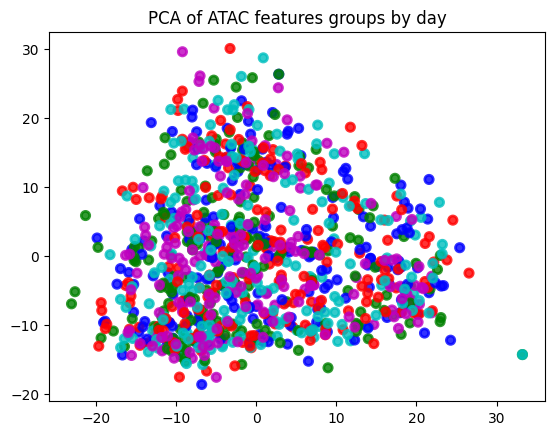

In [33]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

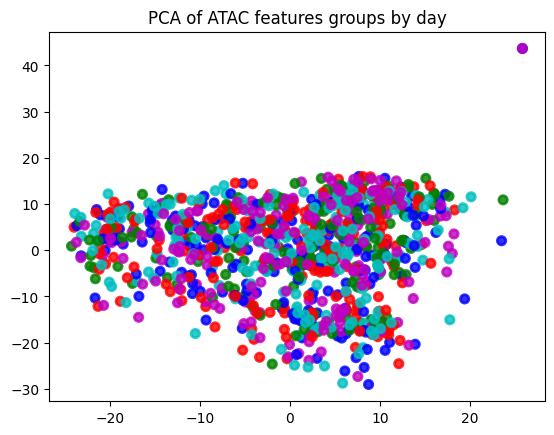

In [34]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

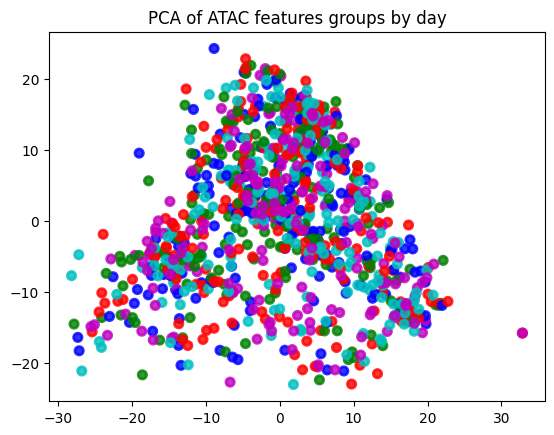

In [35]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

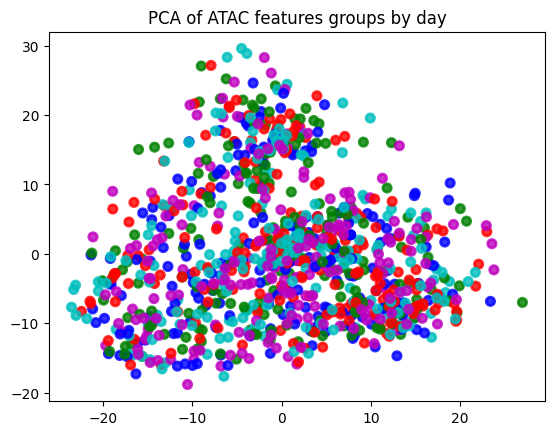

In [36]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

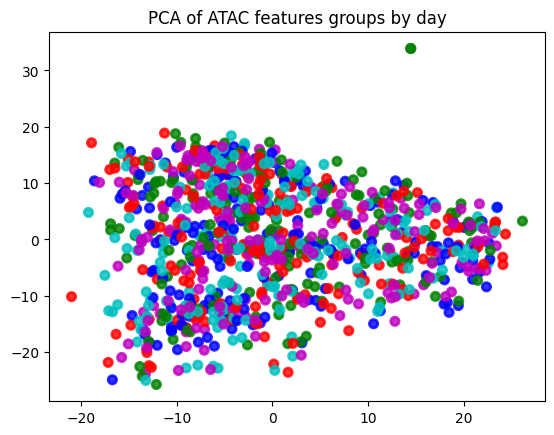

In [37]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

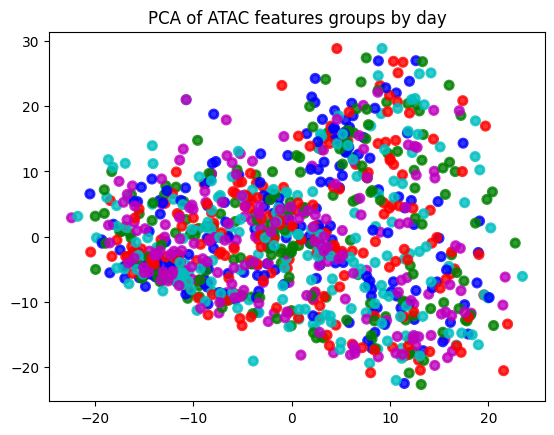

In [38]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

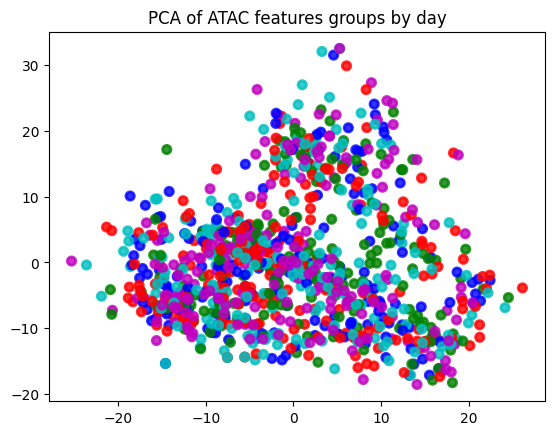

In [39]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

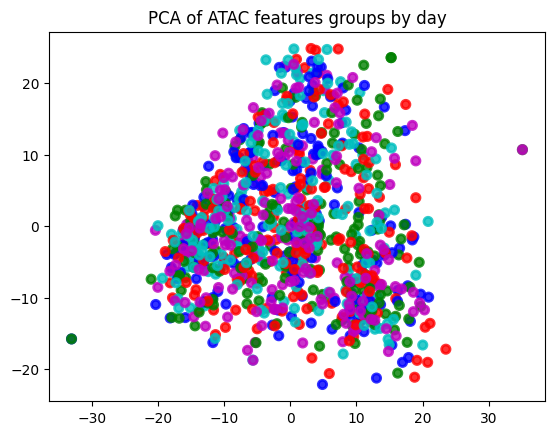

In [40]:
features_per_day = 100
cluster_features = []
cluster_tags = []

for dataset in all_data:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dataset[ind]['inputs'])
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

--------------------------------------------------------------------------

## Строим кластера с усреднением случайных векторов по 10 штук

In [72]:
all_data = [train_dataset, test_dataset]

  0%|                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]


 20%|█████████████████████████████████████▊                                                                                                                                                       | 1/5 [00:20<01:21, 20.35s/it]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]


 40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2/5 [00:40<01:01, 20.37s/it]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3/5 [01:01<00:40, 20.42s/it]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4/5 [01:21<00:20, 20.40s/it]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]


  0%|                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]

[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


 20%|█████████████████████████████████████▊                                                                                                                                                       | 1/5 [00:15<01:00, 15.19s/it]

[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


 40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2/5 [00:30<00:45, 15.21s/it]

[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3/5 [00:45<00:30, 15.22s/it]

[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4/5 [01:00<00:15, 15.21s/it]

[ Reading test_multi_inputs.h5 file ... ]
[ Reading test_multi_inputs.h5 file is complete. ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.21s/it]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

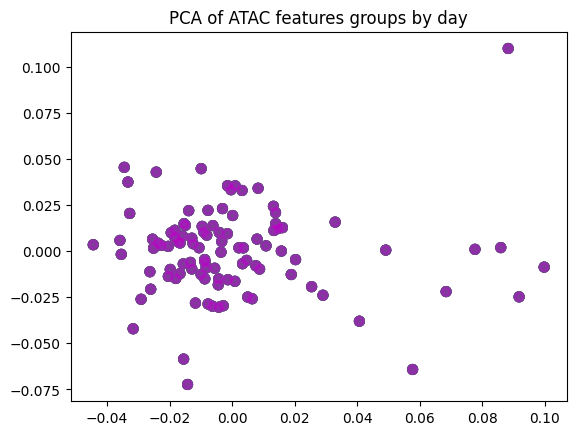

In [97]:
features_per_day = 10000
mean_count = 100
cluster_features = []
cluster_tags = []

for mode in ['train', 'test']:
    for day in tqdm(days):
        train_dataset.rebase('multi', mode)
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in range(features_per_day // mean_count):
            cluster_features.append(np.mean(dataset[ind * mean_count:(ind + 1) * mean_count]['inputs'], axis=1))
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], alpha=0.5, color=colors, lw=2, label=cluster_tags)  #  
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

In [98]:
features

array([[-0.00142513,  0.03547196],
       [-0.00149909,  0.00946675],
       [-0.0166207 ,  0.0044228 ],
       ...,
       [ 0.06850022, -0.02193503],
       [ 0.09988222, -0.00866946],
       [ 0.08599779,  0.00191198]])

In [99]:
features.shape

(1000, 2)

In [100]:
features[:, 0].shape

(1000,)

In [101]:
days

[3, 4, 7, 2, 10]

Text(0.5, 1.0, 'PCA of ATAC features groups by day')

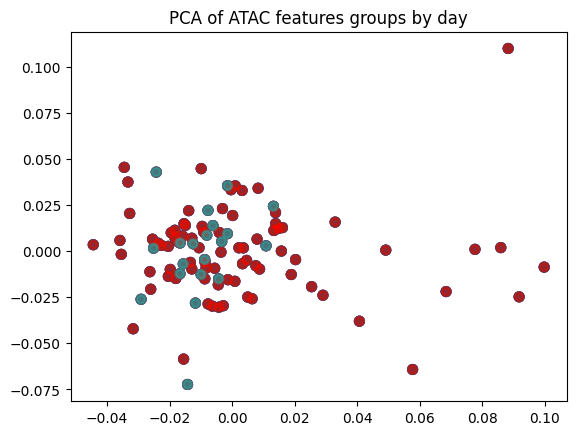

In [132]:
plt.scatter(features[:-180, 0], features[:-180, 1], alpha=0.5, color=colors[:-180], lw=2, label=cluster_tags[:-180])  #  
plt.title("PCA of ATAC features groups by day")